In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
import os

plt.style.use('ggplot')

In [2]:
directory = r'D:\python data\trump_biden'


if os.path.exists(directory):
    for file in os.listdir(directory):
        os.remove(os.path.join(directory,file))
    os.rmdir(directory)
os.makedirs(directory)

import kaggle
kaggle.api.dataset_download_files('headsortails/us-election-2020-presidential-debates',
                                  os.path.join('D:\python data','trump_biden'),
                                  unzip=True,quiet=False)

In [3]:
for file in os.listdir(directory):
    if file.endswith('.csv'):
        print(file)

us_election_2020_1st_presidential_debate.csv
us_election_2020_2nd_presidential_debate.csv
us_election_2020_biden_town_hall.csv
us_election_2020_trump_town_hall.csv
us_election_2020_vice_presidential_debate.csv


In [4]:
df=pd.read_csv(os.path.join(directory,'us_election_2020_1st_presidential_debate.csv'))
df

,speaker,minute,text
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...
1,Chris Wallace,02:10,This debate is being conducted under health an...
2,Vice President Joe Biden,02:49,"How you doing, man?"
3,President Donald J. Trump,02:51,How are you doing?
4,Vice President Joe Biden,02:51,I’m well.
...,...,...,...
784,Chris Wallace,01:10:43,"Gentlemen, just say that’s the end of it [cros..."
785,President Donald J. Trump,01:10:47,I want to see an honest ballot count.
786,Chris Wallace,01:10:48,We’re going to leave it there-
787,President Donald J. Trump,01:10:49,And I think he does too-


In [5]:
df=df.replace({'Chris Wallace:':'Chris Wallace',
               'President Donald J. Trump':'Donald Trump',
               'Vice President Joe Biden':'Joe Biden'})

In [6]:
df['seconds']=df['minute'].apply(lambda x:
                   int(x.split(':')[0])*3600+int(x.split(':')[1])*60+int(x.split(':')[2]) if isinstance(x,str) and x.count(':')==2 else
                   int(x.split(':')[0])*60+int(x.split(':')[1]) if isinstance(x,str) and x.count(':')==1 else None)

df=df.sort_values('seconds')

In [7]:
df['seconds spoken']=df['seconds'].shift(-1)-df['seconds']

In [8]:
df['words spoken']=[len(text.split(' ')) for text in df['text']]

In [9]:
df['seconds per word']=df['seconds spoken']/df['words spoken']

In [10]:
df['order of speech']=df.groupby('speaker')['text'].transform('cumcount')+1


In [11]:
df

,speaker,minute,text,seconds,seconds spoken,words spoken,seconds per word,order of speech
180,Donald Trump,00:15,"Well, I’ve spoken to the companies and we can ...",15.0,7.0,31,0.225806,1
181,Joe Biden,00:22,God.,22.0,1.0,1,1.000000,1
182,Donald Trump,00:23,It is a very political thing. I’ve spoken to P...,23.0,15.0,61,0.245902,2
183,Chris Wallace,00:38,So you’re suggesting that the head of your Ope...,38.0,4.0,13,0.307692,1
184,Donald Trump,00:42,"I disagree with him. No, I disagree with both ...",42.0,7.0,38,0.184211,3
...,...,...,...,...,...,...,...,...
785,Donald Trump,01:10:47,I want to see an honest ballot count.,4247.0,1.0,8,0.125000,313
786,Chris Wallace,01:10:48,We’re going to leave it there-,4248.0,1.0,6,0.166667,224
787,Donald Trump,01:10:49,And I think he does too-,4249.0,1.0,6,0.166667,314
788,Chris Wallace,01:10:50,… to be continued in more debates as we go on....,4250.0,NaN,122,NaN,225


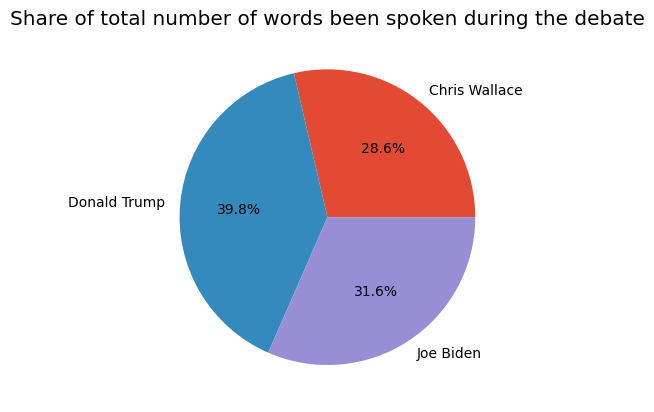

In [12]:
df.groupby('speaker')['words spoken'].count().plot.pie(autopct=lambda p: f'{p:.1f}%',label='',title='Share of total number of words been spoken during the debate')
plt.show()

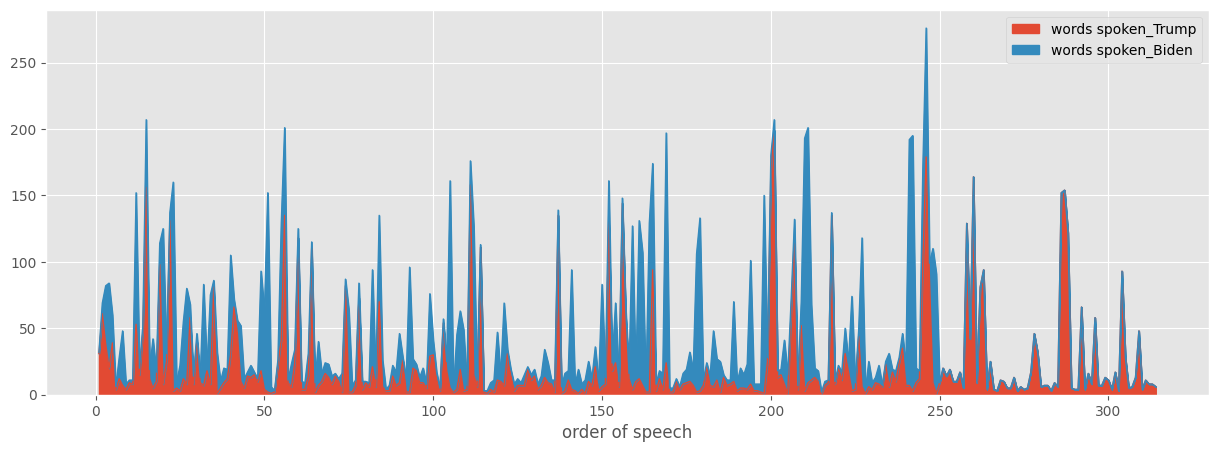

In [13]:
g_biden=df[df['speaker']=='Joe Biden'][['speaker','seconds spoken','words spoken','seconds per word','order of speech']]
g_trump=df[df['speaker']=='Donald Trump'][['speaker','seconds spoken','words spoken','seconds per word','order of speech']]
merged=g_trump.merge(g_biden,on='order of speech',how='left')
merged.columns=[col.replace('_x','_Trump').replace('_y','_Biden') for col in merged.columns]

fig,ax=plt.subplots(figsize=(15,5))
merged.plot.area(ax=ax,x='order of speech',y=['words spoken_Trump','words spoken_Biden'],lw=1)
plt.show()

(-0.5, 1.2)

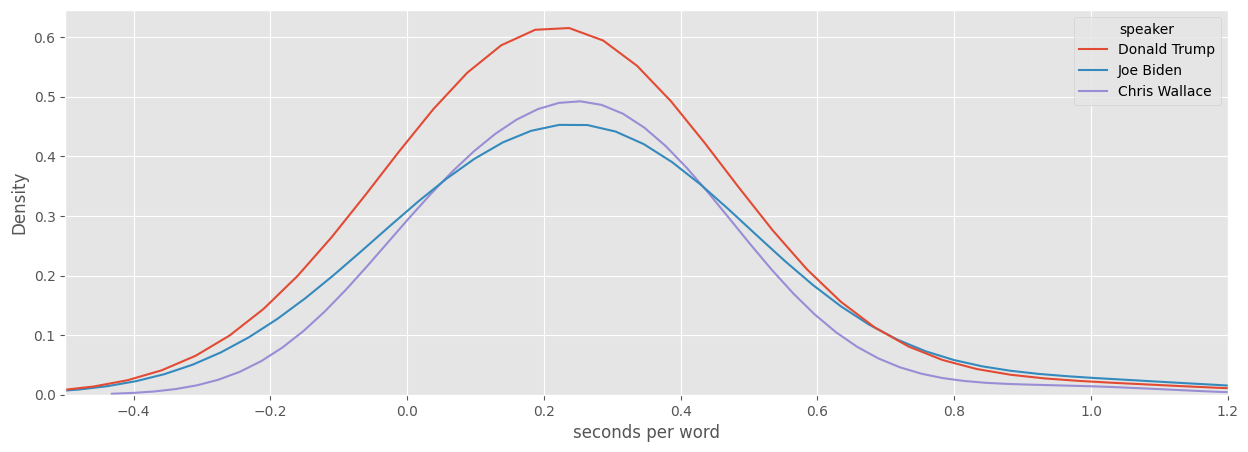

In [14]:
plt.figure(figsize=(15,5))
sns.kdeplot(df,x='seconds per word',hue='speaker')
plt.xlim(-0.5,1.2)

Most frequent words used by Trump and Biden

In [15]:
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

In [16]:
print('most frequntly used words by Trump')

pd.Series([word.strip().replace('.','').replace(',','') for text in df[df['speaker']=='Donald Trump']['text'] for word in text.split(' ') if word not in stop_words]).value_counts(ascending=False)[:10]

most frequntly used words by Trump


I         131
people     63
And        60
You        50
They       43
going      41
don’t      40
want       40
know       39
would      36
Name: count, dtype: int64

In [17]:
print('most frequntly used words by Biden')

pd.Series([word.strip().replace('.','').replace(',','') for text in df[df['speaker']=='Joe Biden']['text'] for word in text.split(' ') if word not in stop_words]).value_counts(ascending=False)[:10]

most frequntly used words by Biden


people    67
I         63
going     60
He        59
And       58
fact      37
The       34
way       31
it        27
get       27
Name: count, dtype: int64